# Logistic Regression TensorFlow Learning Diary
This notebook documents my learning and practice process of using the Python `TensorFlow` framework to train a logistic regression model (or a two-layer neural network) to classify Harris and Trump voters on the 2024 CES survey dataset.

I used the following resources:
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/core/logistic_regression_core.ipynb#scrollTo=VMXEhrZuKECV
* https://www.tensorflow.org/guide/core/logistic_regression_core
* https://d2l.ai/index.html#
* https://developers.google.com/machine-learning/crash-course/overfitting/regularization

Logistic regression is often used for binary classification.

Linear component: $z = w^\top x$
Apply logistic (sigmoid) activation: $y = \sigma(z)$ where $\sigma(z) = \frac{e^z}{1 + e^z}$

Binary cross entropy loss is often used: $L_{CE}(y\_pred, y) = -y log(y\_pred) - (1-y)log(1-y\_pred)$

In [2]:
# workplace setup (copied from TensorFlow logistic regression documentation)
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import regularizers

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.18.0


In [3]:
# data
url = "https://github.com/taliafabs/STA496/raw/main/MidtermPaper/data/ces24_analysis_data.parquet"
ces24_df = pd.read_parquet(url, engine="pyarrow")

In [4]:
# data preparation
race_map = {
    'White': 'White',
    'Black': 'Black',
    'Hispanic': 'Hispanic',
    'Asian': 'All Other Races',
    'Two or more races': 'All Other Races',
    'Other': 'All Other Races',
    'Native American': 'All Other Races',
    'Middle Eastern': 'All Other Races'
}
ces24_df['race'] = ces24_df['race'].map(race_map)

ces24_df = ces24_df[(ces24_df['gender'] == "Woman") | (ces24_df['gender'] == "Man")]

In [5]:
# dummy and interaction variables for easier logistic model building
def create_dummy_interaction(col1, col2):
  result = pd.DataFrame()
  col1_dummies = pd.get_dummies(col1, drop_first=True)
  col2_dummies = pd.get_dummies(col2, drop_first=True)
  for col1_val in col1_dummies.columns:
    for col2_val in col2_dummies.columns:
      result[f'{col1_val}_{col2_val}'] = col1_dummies[col1_val] * col2_dummies[col2_val]
  return result

In [6]:
# create the interaction terms
race_gender_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['gender'])
race_educ_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['educ'])
race_region_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['region'])
race_urban_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['urbancity'])

# ces24_binary = ces24_df[ces24_df['presvote24'] != 'Other']
ces24_dummies = pd.concat([
    pd.get_dummies(ces24_df, drop_first=True),
    race_gender_interaction_terms,
    race_educ_interaction_terms,
    race_region_interaction_terms,
    race_urban_interaction_terms,
], axis=1)

# make it binary (remove third party voters for modeling part)
ces24_dummies[ces24_dummies['presvote24_Other'] == 0]

# drop the presvote24 related columns
ces24_dummies = ces24_dummies.drop(columns=['presvote24_Other'])
# ces24_dummies = ces24_dummies.drop(columns=['presvote24_Donald Trump (R)'])
ces24_dummies = ces24_dummies.drop(columns=['presvote24_Kamala Harris (D)'])
# drop birth year
ces24_dummies = ces24_dummies.drop(columns=['birthyr'])
ces24_dummies.head()

,vote_trump,commonweight,commonpostweight,race_Black,race_Hispanic,race_White,age_bracket_25–34,age_bracket_35–44,age_bracket_45–54,age_bracket_55–64,...,Black_Rural area,Black_Other,Hispanic_Suburb,Hispanic_Town,Hispanic_Rural area,Hispanic_Other,White_Suburb,White_Town,White_Rural area,White_Other
0,0,0.418897,0.180057,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0.946650,0.700897,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0,0.194303,0.046275,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,0.083223,0.008897,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0.596598,0.555395,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Split the data into training and test datasets

In [7]:
train_dataset = ces24_dummies.sample(frac=0.25, random_state=1)
test_dataset = ces24_dummies.drop(train_dataset.index)

In [7]:
len(train_dataset)

11409

In [8]:
len(test_dataset)

34227

In [9]:
len(train_dataset) + len(test_dataset) == len(ces24_dummies)

True

In [10]:
type(test_dataset), type(train_dataset)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [8]:
# get features and targets for training and test data
X_train, y_train = train_dataset.drop(columns=['vote_trump']).values, train_dataset['vote_trump'].values
X_test, y_test = test_dataset.drop(columns=['vote_trump']).values, test_dataset['vote_trump'].values

# convert to tensors
X_train, y_train = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test, y_test = tf.convert_to_tensor(X_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [9]:
type(X_train) # <tensorflow.python.framework.ops.EagerTensor>

tensorflow.python.framework.ops.EagerTensor

In [10]:
# reshape (I got this correction from ChatGPT)
# X_train = tf.reshape(X_train, (-1, 1))
X_train.shape

TensorShape([11409, 140])

In [11]:
# X_test = tf.reshape(X_test, (-1, 1))
X_test.shape

TensorShape([34227, 140])

In [12]:
y_train.shape, y_test.shape

(TensorShape([11409]), TensorShape([34227]))

We use binary cross entropy loss for logistic ML models.


In [13]:
# helper function to compute the binary cross entropy loss
def loss(y_pred, y):
  cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(cross_entropy_loss)

In [14]:
# the accuracy is the overall percentage of examples that the model classified correctly
def accuracy(y_pred, y):
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = tf.cast(y_pred >= 0.5, tf.float32) # classify an example in the positive class if the prob of this is >= 0.5
  return tf.reduce_mean(tf.cast(y_pred_class == y, tf.float32))

In [15]:
# logistic regression model (using code from TensorFlow documentation)
class LogisticRegression(tf.Module):

  def __init__(self):
    """
    Initialize the logistic regression model class.
    """
    self.built = False

  def __call__(self, x, train=True):
    if not self.built: # if not pre built, randomly generate the weights and bias
      rand_weights = tf.random.normal(shape=[x.shape[-1], 1], seed=24)
      rand_bias = tf.random.normal(shape=[], seed=24)
      self.W = tf.Variable(rand_weights)
      self.b = tf.Variable(0.0)
      self.built = True
    z = tf.add(tf.matmul(x, self.W), self.b) # z = Xw + b
    z = tf.squeeze(z, axis=1) # remove the extra dimension
    if train:
      return z
    return tf.nn.sigmoid(z) # y_pred = sigmoid(z)

optimization

In [16]:
# try the model out once, untrained
model = LogisticRegression()
model(X_train)
# X_train.shape

<tf.Tensor: shape=(11409,), dtype=float32, numpy=
array([-10.79324  ,  -3.2802353,   1.3278469, ...,  -1.2776482,
        -0.5430082,   2.6860433], dtype=float32)>

Chat GPT interaction to fix indentation error:


```
fix indentation error       # print(f"batch size: {batch_size}, learning rate: {learning_rate}, num epochs: {num_epoch}")
      # z = model(train_dataset.drop(columns=['presvote24_Donald Trump (R)']).values)

# dictionary to store the different accuracies
accuracies = {}

# try out the different batch sizes and learning rates
for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    for num_epoch in num_epochs:
      model = LogisticRegression()
      optimizer = tf.optimizers.SGD(learning_rate)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
      epoch_loss = 0
      num_batches = 0

      # training loop
      for epoch in range(num_epoch): # Fixed: range(num_epochs) -> range(num_epoch)
        for x_batch, y_batch in train_dataset:
          with tf.GradientTape() as tape:
            z = model(x_batch)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_batch, logits=z)
            loss = tf.reduce_mean(loss)
          gradients = tape.gradient(loss, [model.W, model.b])
          optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
          epoch_loss += loss.numpy()
          num_batches += 1
        print(f"Epoch {epoch+1}/{num_epoch} loss: {epoch_loss / num_batches:.4f}")
      # train_loss = epoch_loss / num_batches
      # train_accuracy = accuracy(model(X_train), y_train)
      # test_accuracy = accuracy(model(X_test), y_test)
      # report validation accuracy
      probs = model(X_test, train=False)
      y_preds = tf.cast(probs >= 0.5, tf.float32)
      accuracies[(batch_size, learning_rate, num_epoch)] = tf.reduce_mean(tf.cast(y_preds == y_test, tf.float32)).numpy()

accuracies


ChatGPT said:
Here's the cleaned-up version of your code with proper indentation and minor clarifications:

python
Copy
Edit
# dictionary to store the different accuracies
accuracies = {}

# try out the different batch sizes and learning rates
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epoch in num_epochs:
            model = LogisticRegression()
            optimizer = tf.optimizers.SGD(learning_rate)
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
            train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
            epoch_loss = 0
            num_batches = 0

            # training loop
            for epoch in range(num_epoch):
                epoch_loss = 0  # reset loss per epoch
                num_batches = 0
                for x_batch, y_batch in train_dataset:
                    with tf.GradientTape() as tape:
                        z = model(x_batch)  # raw logits
                        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_batch, logits=z)
                        loss = tf.reduce_mean(loss)
                    gradients = tape.gradient(loss, [model.W, model.b])
                    optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
                    epoch_loss += loss.numpy()
                    num_batches += 1
                print(f"Epoch {epoch + 1}/{num_epoch} loss: {epoch_loss / num_batches:.4f}")

            # Evaluate accuracy on test set
            probs = model(X_test, train=False)  # apply sigmoid
            y_preds = tf.cast(probs >= 0.5, tf.float32)
            accuracy_val = tf.reduce_mean(tf.cast(y_preds == y_test, tf.float32)).numpy()
            accuracies[(batch_size, learning_rate, num_epoch)] = accuracy_val

print(accuracies)
Notes:
Reset epoch_loss and num_batches inside the epoch loop to avoid accumulating losses across epochs.

Make sure X_test and y_test are tensors with proper shapes and types.

The final print(accuracies) will show validation accuracies for all hyperparameter combos.

Let me know if you want me to help add validation splits or save the best model!








You said:
where was the indent error


ChatGPT said:
The main indentation issues were:

epoch_loss and num_batches counters were initialized outside the epoch loop and never reset inside each epoch, causing cumulative loss across epochs.

The entire epoch loop body needed consistent indentation — especially the inner loop over batches and the print statement.
```



In [20]:
# try out different numbers of iterations and different learning rates
num_epochs = [10, 20, 50, 100, 150]
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [16, 32, 64, 128]
optimizers = ['sgd', 'adam'] # should i try out rms prop?

In [21]:
# dictionary to store the different accuracies
# i used chat gpt to debug this and fix an indentation error
accuracies = {}
losses = {}

# try out the different batch sizes and learning rates
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epoch in num_epochs:
            print(f"batch size: {batch_size}, learning rate: {learning_rate}, num epochs: {num_epoch}")
            model = LogisticRegression()
            optimizer = tf.optimizers.SGD(learning_rate)
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
            train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
            epoch_loss = 0
            num_batches = 0

            # training loop
            for epoch in range(num_epoch):
                epoch_loss = 0  # reset loss per epoch
                num_batches = 0
                for x_batch, y_batch in train_dataset:
                    with tf.GradientTape() as tape:
                        z = model(x_batch)  # raw logits
                        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_batch, logits=z)
                        loss = tf.reduce_mean(loss)
                    gradients = tape.gradient(loss, [model.W, model.b])
                    optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
                    epoch_loss += loss.numpy()
                    num_batches += 1
                print(f"Epoch {epoch + 1}/{num_epoch} loss: {epoch_loss / num_batches:.4f}")

            # Evaluate accuracy on test set
            probs = model(X_test, train=False)  # apply sigmoid
            y_preds = tf.cast(probs >= 0.5, tf.float32)
            accuracy_val = tf.reduce_mean(tf.cast(y_preds == y_test, tf.float32)).numpy()
            accuracies[(batch_size, learning_rate, num_epoch)] = accuracy_val


# print(accuracies)

batch size: 16, learning rate: 0.01, num epochs: 10


KeyboardInterrupt: 

In [61]:
print(accuracies)

{(16, 0.01, 10): np.float32(0.9102755), (16, 0.01, 20): np.float32(0.9172583), (16, 0.01, 50): np.float32(0.92482543), (16, 0.01, 100): np.float32(0.9256143), (16, 0.01, 150): np.float32(0.9263155), (16, 0.001, 10): np.float32(0.6817425), (16, 0.001, 20): np.float32(0.79486954), (16, 0.001, 50): np.float32(0.88725275), (16, 0.001, 100): np.float32(0.91369385), (16, 0.001, 150): np.float32(0.91699535), (16, 0.0001, 10): np.float32(0.46539283), (16, 0.0001, 20): np.float32(0.51360035), (16, 0.0001, 50): np.float32(0.58792764), (16, 0.0001, 100): np.float32(0.6848102), (16, 0.0001, 150): np.float32(0.69792855), (16, 1e-05, 10): np.float32(0.5665118), (16, 1e-05, 20): np.float32(0.47897857), (16, 1e-05, 50): np.float32(0.46784702), (16, 1e-05, 100): np.float32(0.5260759), (16, 1e-05, 150): np.float32(0.5434014), (32, 0.01, 10): np.float32(0.88690215), (32, 0.01, 20): np.float32(0.9155053), (32, 0.01, 50): np.float32(0.92123175), (32, 0.01, 100): np.float32(0.9214655), (32, 0.01, 150): np.f

In [65]:
# make it a df
accuracies_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['accuracy'])
accuracies_df

,accuracy
"(16, 0.01, 10)",0.910276
"(16, 0.01, 20)",0.917258
"(16, 0.01, 50)",0.924825
"(16, 0.01, 100)",0.925614
"(16, 0.01, 150)",0.926315
...,...
"(128, 1e-05, 10)",0.486312
"(128, 1e-05, 20)",0.586730
"(128, 1e-05, 50)",0.502352
"(128, 1e-05, 100)",0.440062


In [62]:
# best accuracy for minibatch so far
best_accuracy = max(accuracies, key=accuracies.get)
print(f"Best accuracy before regularization is: {accuracies[best_accuracy]} with batch size: {best_accuracy[0]}, learning rate: {best_accuracy[1]}, num epochs: {best_accuracy[2]}")

Best accuracy before regularization is: 0.9263154864311218 with batch size: 16, learning rate: 0.01, num epochs: 150


# run this

In [ ]:
# consider regularization???
lambdas = [] # try out different regularization parameters

In [ ]:
# see if l1 or l2 improves performance
# why would l2 be used?
# encourages smaller weights, prevents certain features from having too much influence, guards against overfitting

In [69]:
# trying higher learning rates and more epochs
num_epochs = [20, 50, 100, 200]
learning_rates = [0.1, 0.05, 0.01, 0.001]
batch_sizes = [32, 64, 128, 256]
validation_accuracies = {}

# try out the different combinations (this will take a while to run)
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epoch in num_epochs:
            print(f"batch size: {batch_size}, learning rate: {learning_rate}, num epochs: {num_epoch}")
            model = LogisticRegression()
            optimizer = tf.optimizers.SGD(learning_rate)
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
            train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
            epoch_loss = 0
            num_batches = 0

            # training loop
            for epoch in range(num_epoch):
                epoch_loss = 0  # reset loss per epoch
                num_batches = 0
                for x_batch, y_batch in train_dataset:
                    # forward pass
                    with tf.GradientTape() as tape:
                        z = model(x_batch)  # raw logits
                        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_batch, logits=z)
                        loss = tf.reduce_mean(loss)
                    # backward pass
                    gradients = tape.gradient(loss, [model.W, model.b])
                    optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
                    epoch_loss += loss.numpy()
                    num_batches += 1
                print(f"Epoch {epoch + 1}/{num_epoch} loss: {epoch_loss / num_batches:.4f}")

            # Evaluate accuracy on test set
            probs = model(X_test, train=False)  # apply sigmoid
            y_preds = tf.cast(probs >= 0.5, tf.float32)
            accuracy_val = tf.reduce_mean(tf.cast(y_preds == y_test, tf.float32)).numpy()
            accuracies[(batch_size, learning_rate, num_epoch)] = accuracy_val

Streaming output truncated to the last 5000 lines.
Epoch 63/200 loss: 0.2256
Epoch 64/200 loss: 0.2258
Epoch 65/200 loss: 0.2251
Epoch 66/200 loss: 0.2253
Epoch 67/200 loss: 0.2246
Epoch 68/200 loss: 0.2244
Epoch 69/200 loss: 0.2247
Epoch 70/200 loss: 0.2236
Epoch 71/200 loss: 0.2234
Epoch 72/200 loss: 0.2234
Epoch 73/200 loss: 0.2230
Epoch 74/200 loss: 0.2231
Epoch 75/200 loss: 0.2228
Epoch 76/200 loss: 0.2224
Epoch 77/200 loss: 0.2221
Epoch 78/200 loss: 0.2220
Epoch 79/200 loss: 0.2219
Epoch 80/200 loss: 0.2218
Epoch 81/200 loss: 0.2213
Epoch 82/200 loss: 0.2212
Epoch 83/200 loss: 0.2207
Epoch 84/200 loss: 0.2205
Epoch 85/200 loss: 0.2207
Epoch 86/200 loss: 0.2204
Epoch 87/200 loss: 0.2201
Epoch 88/200 loss: 0.2199
Epoch 89/200 loss: 0.2195
Epoch 90/200 loss: 0.2201
Epoch 91/200 loss: 0.2194
Epoch 92/200 loss: 0.2193
Epoch 93/200 loss: 0.2190
Epoch 94/200 loss: 0.2194
Epoch 95/200 loss: 0.2192
Epoch 96/200 loss: 0.2187
Epoch 97/200 loss: 0.2182
Epoch 98/200 loss: 0.2183
Epoch 99/200 

In [ ]:
best_accuracy = max(validation_accuracies, key=validation_accuracies.get)
print(f"Best accuracy before regularization is: {validation_accuracies[best_accuracy]} with batch size: {best_accuracy[0]}, learning rate: {best_accuracy[1]}, num epochs: {best_accuracy[2]}")

In [5]:
validation_accuracies

# regularization

In [ ]:
# L2 regularization
lambdas = [0.001, 0.01, 1]
validation_accuracies_regularized = {}
best_bs = best_accuracy[0] # batch size
best_lr = best_accuracy[1] # learning rate
best_ne = best_accuracy[2] # num epochs

for lamb in lambdas:
  print(f"lambda: {lamb}")
  model = LogisticRegression()
  optimizer = tf.optimizers.SGD(best_lr)
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
  epoch_loss = 0
  num_batches = 0

  for epoch in range(best_ne):
    epoch_loss = 0  # reset loss per epoch
    num_batches = 0
    for x_batch, y_batch in train_dataset:
      # forward pass
      with tf.GradientTape() as tape:
        z = model(x_batch)  # raw logits
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_batch, logits=z))
        # L2 reg term 0.5 * lambda * (w • w)
        reg_loss = 0.5 * lamb * tf.reduce_sum(tf.square(model.W))
        loss += reg_loss
      gradients = tape.gradient(loss, [model.W, model.b])
      optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
      epoch_loss += loss.numpy()
      num_batches += 1
      print(f"Epoch {epoch + 1}/{num_epoch} loss: {epoch_loss / num_batches:.4f}")

In [ ]:
# find the best lambda
best_lambda = max(validation_accuracies_regularized, key=validation_accuracies_regularized.get)

In [ ]:
# actually compile it now

In [61]:
from tensorflow.keras import regularizers

logistic_model = keras.Sequential([
    keras.layers.Dense(1,
                       activation='sigmoid',
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer = regularizers.l2(0.001)
                       )
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
logistic_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
    loss='binary_crossentropy',
    metrics=['accuracy', 'loss']
)

In [34]:
X_train.shape

TensorShape([11409, 140])

In [37]:
y_train.shape

TensorShape([11409])

In [17]:
# train_dataset = ces24_df.sample(frac=0.75, random_state=0)
# test_dataset = ces24_df.drop(train_dataset.index)
# train and test dummy data
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_dataset = ces24_dummies.sample(frac=0.75, random_state=0)
test_dataset = ces24_dummies.drop(train_dataset.index)

# feature matrices and target vectors
X_train, y_train = train_dataset.drop(columns=['vote_trump']), train_dataset['vote_trump']
X_test, y_test = test_dataset.drop(columns=['vote_trump']), test_dataset['vote_trump']

lr, l2 = 0.05, 0.001
# define the logistic model architecture
logistic_model = keras.Sequential([
    keras.layers.Dense(1,
                       activation='sigmoid',
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer = regularizers.l2(l2)
                       )
])

# compile model using adam optimizer, binary cross entropy loss, and accuracy metric
logistic_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit it
history = logistic_model.fit(X_train, y_train,
                             epochs=100,
                             batch_size=32,
                             validation_data=(X_test, y_test),
                             verbose=0)

y_pred_prob = logistic_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6498
           1       0.91      0.92      0.92      4911

    accuracy                           0.93     11409
   macro avg       0.93      0.93      0.93     11409
weighted avg       0.93      0.93      0.93     11409



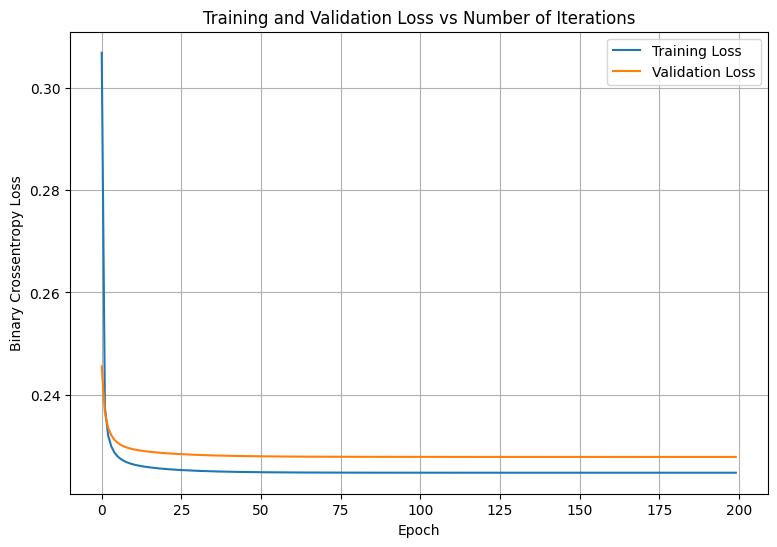

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Training and Validation Loss vs Number of Iterations')
plt.legend()
plt.grid(True)
plt.show()

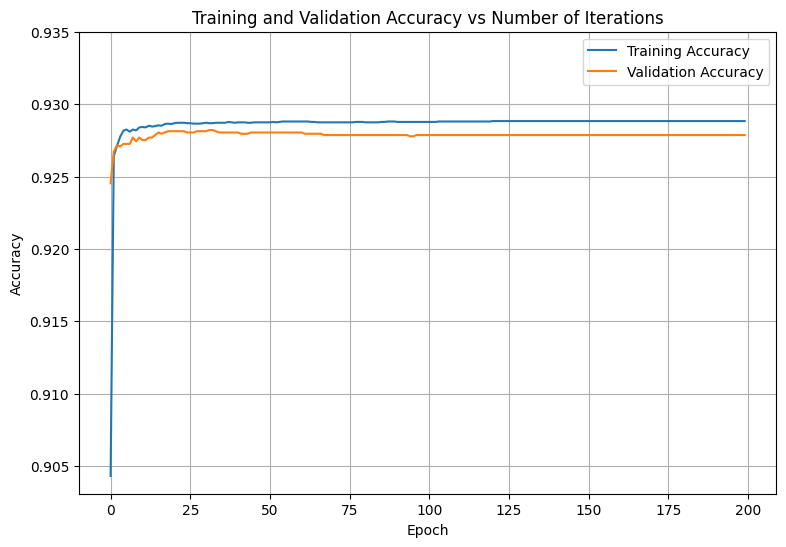

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Number of Iterations')
plt.legend()
plt.grid(True)
plt.ylim(top=0.935)
# add vertical line and text to consider stopping earlier (at 100 epochs?)
plt.show()
